<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/all_town_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 町の全スコア
- input:
    - population_master.csv
        - 町丁ごとの位置
    - train_station.csv
        - 最寄り駅
        - 最寄り駅から主要駅までの時間
    - childcare_score.csv
        - 子育てスコア
            - 保育園スコア
            - 幼稚園スコア
            - 児童館スコア
    - education_score.csv
        - 教育スコア
            - 小学校スコア
            - 中学校スコア
            - 図書館スコア
    - convenience_score.csv
        - 利便性スコア
            - 買い物スコア
            - 駅スコア
    - environment_score.csv
        - 周辺環境スコア
            - 公園スコア
            - 運動場スコア
            - 体育館スコア
            - プールスコア
    - medical_score.csv
        - 医療スコア
            - 病院スコア
            - 小児科スコア
            - 薬局スコア
    - crime_score.csv
        - 治安スコア
    - population_core.csv
        - ○○割合スコア
    - land_price_score.csv
        - 家賃
- output:
    - all_town_score.csv
        - 町丁ごとの全スコアデータ

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
output_file = 'all_town_score.csv'

### 人口マスタ

In [6]:
df_population = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[
    ['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']
].set_index('地域ID')
print(df_population.shape)
df_population.head()

(3145, 5)


,市区町村名,町名,町丁目,緯度,経度
地域ID,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511
101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944
101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039
101007,千代田区,大手町,大手町１丁目,35.688067,139.764353
101008,千代田区,大手町,大手町２丁目,35.686416,139.768530


### 最寄り駅

In [7]:
major_station = ['東京駅', '上野駅', '池袋駅', '新宿駅', '渋谷駅', '品川駅']
df_train_station = pd.read_csv(os.path.join(DIR_NAME, 'train_station_route.csv'))[
    ['no', 'name'] + major_station
].rename(columns={'name':'最寄り駅'}).set_index('no')
print(df_train_station.shape)

(3141, 7)


In [8]:
# 最寄り駅と目的地が同じ場合に0分になるように補正
for station in major_station:
    offset = df_train_station[df_train_station['最寄り駅'] == station].iloc[0][station]
    print(station, offset)
    df_train_station[station] = df_train_station[station] - offset

東京駅 4.0
上野駅 4.0
池袋駅 2.0
新宿駅 2.0
渋谷駅 1.0
品川駅 2.0


In [9]:
df_train_station.head()

,最寄り駅,東京駅,上野駅,池袋駅,新宿駅,渋谷駅,品川駅
no,,,,,,,
101003,東京駅,0.0,9.0,19.0,18.0,24.0,13.0
101004,東京駅,0.0,9.0,19.0,18.0,24.0,13.0
101005,有楽町駅,4.0,12.0,24.0,25.0,24.0,13.0
101007,大手町駅,4.0,17.0,18.0,23.0,22.0,21.0
101008,大手町駅,4.0,17.0,18.0,23.0,22.0,21.0


### 子育てスコア

In [10]:
df_childcare = pd.read_csv(os.path.join(DIR_NAME, 'childcare_score.csv'))[
    ['地域ID', '幼稚園スコア', '保育園スコア', '児童館スコア', '子育てスコア']
].set_index('地域ID')
print(df_childcare.shape)
df_childcare.head()

(3145, 4)


,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア
地域ID,,,,
101003,2.293,0.125,0.367,0.182
101004,1.935,0.093,0.200,0.090
101005,2.736,0.127,0.280,0.284
101007,2.449,0.208,0.395,0.264
101008,2.948,0.236,0.652,0.468


### 教育スコア

In [11]:
df_education = pd.read_csv(os.path.join(DIR_NAME, 'education_score.csv'))[
    ['地域ID', '小学校スコア', '中学校スコア', '図書館スコア', '教育スコア']
].set_index('地域ID')
print(df_education.shape)
df_education.head()

(3145, 4)


,小学校スコア,中学校スコア,図書館スコア,教育スコア
地域ID,,,,
101003,3.112,1.541,0.991,1.814
101004,2.518,1.546,0.942,1.399
101005,2.438,1.609,1.280,1.486
101007,2.692,1.919,2.365,2.221
101008,3.768,1.583,2.301,2.659


### 利便性スコア

In [12]:
df_convenience = pd.read_csv(os.path.join(DIR_NAME, 'convenience_score.csv'))[
    ['地域ID', '買い物スコア', '駅スコア', '利便性スコア', '最寄駅(距離)']
].set_index('地域ID')
print(df_convenience.shape)
df_convenience.head()

(3145, 4)


,買い物スコア,駅スコア,利便性スコア,最寄駅(距離)
地域ID,,,,
101003,4.516,4.975,4.953,0.054
101004,3.949,3.929,4.327,0.315
101005,3.785,4.484,4.537,0.228
101007,3.421,3.913,3.976,0.317
101008,4.499,2.976,4.074,0.489


### 周辺環境スコア

In [13]:
df_environment = pd.read_csv(os.path.join(DIR_NAME, 'environment_score.csv'))[
    ['地域ID', '公園スコア', '運動場スコア', '体育館スコア', 'プールスコア', '周辺環境スコア']
].set_index('地域ID')
print(df_environment.shape)
df_environment.iloc[300:305]

(3145, 5)


,公園スコア,運動場スコア,体育館スコア,プールスコア,周辺環境スコア
地域ID,,,,,
103109,1.340,1.831,0.675,4.844,2.320
103110,1.407,1.559,0.806,4.913,2.351
103112,2.137,1.861,0.279,3.468,2.479
103113,2.024,2.564,0.396,3.346,2.539
103114,1.498,2.091,0.606,3.316,2.189


### 医療スコア

In [14]:
df_medical = pd.read_csv(os.path.join(DIR_NAME, 'medical_score.csv'))[
    ['地域ID', '病院スコア', '小児科スコア', '薬局スコア', '医療スコア']
].set_index('地域ID')
print(df_medical.shape)
df_medical.head()

(3145, 4)


,病院スコア,小児科スコア,薬局スコア,医療スコア
地域ID,,,,
101003,3.593,4.338,3.696,4.041
101004,1.590,2.839,1.804,2.053
101005,4.030,3.679,3.526,3.876
101007,4.512,2.925,4.508,4.223
101008,3.927,3.593,3.736,3.887


### 治安

In [15]:
df_crime = pd.read_csv(os.path.join(DIR_NAME, 'crime_score.csv'))[
    ['地域ID', '治安スコア']
].set_index('地域ID')
print(df_crime.shape)
df_crime.head()

(3145, 1)


,治安スコア
地域ID,
101003,0.153
101004,1.393
101005,1.013
101007,0.112
101008,1.236


### 人口分布

In [16]:
df_pop_rate = pd.read_csv(os.path.join(DIR_NAME, 'population_score.csv')).set_index('地域ID')
print(df_pop_rate.shape)
df_pop_rate.head()

(3145, 15)


,乳幼児割合スコア,小学生割合スコア,中学生割合スコア,高校生割合スコア,10代割合スコア,20代割合スコア,30代割合スコア,40代割合スコア,50代割合スコア,60代割合スコア,10代_子割合スコア,20代_子割合スコア,30代_子割合スコア,40代_子割合スコア,50代_子割合スコア
地域ID,,,,,,,,,,,,,,,
101003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 家賃

In [17]:
df_rent_price = pd.read_csv(os.path.join(DIR_NAME, 'land_price_score.csv')).drop(columns=['地価', '地価スコア']).set_index('地域ID')
print(df_rent_price.shape)
df_rent_price.head()

(3145, 4)


,家賃予測_ワンルーム,家賃予測_1K,家賃予測_1LDK,家賃予測_2LDK
地域ID,,,,
101003,13.31,13.74,29.27,45.23
101004,13.56,13.98,29.98,46.38
101005,13.01,13.45,28.43,43.89
101007,12.52,12.99,27.09,41.73
101008,13.13,13.57,28.79,44.46


### 全て結合

In [18]:
df_all_town_score = pd.concat([
    df_population,
    df_train_station,
    df_childcare,
    df_education,
    df_convenience,
    df_environment,
    df_medical,
    df_crime,
    df_pop_rate,
    df_rent_price,
], axis=1)
df_all_town_score.index.name = '地域ID'
print(df_all_town_score.shape)

(3145, 53)


In [19]:
score_cols = [col for col in df_all_town_score.columns if col.endswith('スコア')]
print(len(score_cols))

36


In [20]:
# 自宅から主要駅までの時間を計算(徒歩1分＝80m)
for station in major_station:
    df_all_town_score[station] = (df_all_town_score[station] + df_all_town_score['最寄駅(距離)'] * 1000 / 80 + 0.5).round()
df_all_town_score = df_all_town_score.drop(columns=['最寄駅(距離)'])

In [21]:
# データがないところは、0で埋める
for col in score_cols:
    df_all_town_score[col] = df_all_town_score[col].fillna(0)

In [22]:
df_all_town_score.head()

,市区町村名,町名,町丁目,緯度,経度,最寄り駅,東京駅,上野駅,池袋駅,新宿駅,渋谷駅,品川駅,幼稚園スコア,保育園スコア,児童館スコア,子育てスコア,小学校スコア,中学校スコア,図書館スコア,教育スコア,買い物スコア,駅スコア,利便性スコア,公園スコア,運動場スコア,...,周辺環境スコア,病院スコア,小児科スコア,薬局スコア,医療スコア,治安スコア,乳幼児割合スコア,小学生割合スコア,中学生割合スコア,高校生割合スコア,10代割合スコア,20代割合スコア,30代割合スコア,40代割合スコア,50代割合スコア,60代割合スコア,10代_子割合スコア,20代_子割合スコア,30代_子割合スコア,40代_子割合スコア,50代_子割合スコア,家賃予測_ワンルーム,家賃予測_1K,家賃予測_1LDK,家賃予測_2LDK
地域ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,東京駅,1.0,10.0,20.0,19.0,25.0,14.0,2.293,0.125,0.367,0.182,3.112,1.541,0.991,1.814,4.516,4.975,4.953,1.487,0.0,...,0.926,3.593,4.338,3.696,4.041,0.153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.31,13.74,29.27,45.23
101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,東京駅,4.0,13.0,23.0,22.0,28.0,17.0,1.935,0.093,0.200,0.090,2.518,1.546,0.942,1.399,3.949,3.929,4.327,1.372,0.0,...,0.844,1.590,2.839,1.804,2.053,1.393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.56,13.98,29.98,46.38
101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,有楽町駅,7.0,15.0,27.0,28.0,27.0,16.0,2.736,0.127,0.280,0.284,2.438,1.609,1.280,1.486,3.785,4.484,4.537,1.791,0.0,...,1.064,4.030,3.679,3.526,3.876,1.013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.01,13.45,28.43,43.89
101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,大手町駅,8.0,21.0,22.0,27.0,26.0,25.0,2.449,0.208,0.395,0.264,2.692,1.919,2.365,2.221,3.421,3.913,3.976,1.856,0.0,...,1.096,4.512,2.925,4.508,4.223,0.112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.52,12.99,27.09,41.73
101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,大手町駅,11.0,24.0,25.0,30.0,29.0,28.0,2.948,0.236,0.652,0.468,3.768,1.583,2.301,2.659,4.499,2.976,4.074,1.945,0.0,...,1.140,3.927,3.593,3.736,3.887,1.236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.13,13.57,28.79,44.46


### 出力

In [23]:
df_all_town_score.to_csv(os.path.join(DIR_NAME, output_file), index=True)

### ウェイト設定

In [24]:
# デフォルト値
w_list = {
    '保育園': 9, '幼稚園': 2, '児童館': 6,
    '小学校': 7, '中学校': 5, '図書館': 4,
    '買い物': 8, '駅': 4,
    '公園': 7, '体育館': 3, 'プール': 2, '運動場': 1,
    '病院': 5, '小児科': 9, '薬局': 3,
    '治安': 7,
    '_年代': 20, '_家族構成': 3, '_家賃': 15,
}

In [25]:
# 家族構成と年代から人口割合のウェイトを設定
def set_pop_rate_from_family_age(family, age):
    for a in range(10, 60, 10):
        w_list[f'{a}代割合'] = 0
        w_list[f'{a}代_子割合'] = 0
    
    pop_rate_list = []
    col_name = f'{age}代割合'
    w_list[col_name] = 10       # 親の重みづけ
    pop_rate_list.append(col_name)
    if family == 3:
        col_name = f'{age}代_子割合'
        w_list[col_name] = 20   # 子供の重みづけ
        pop_rate_list.append(col_name)

    return [col + 'スコア' for col in pop_rate_list]

# 家族構成と年代から部屋タイプを取得
def get_room_type_from_family_age(family, age):
    room_type = {
        10: {1:'ワンルーム', 2:'1K', 3:'1K'},
        20: {1:'ワンルーム', 2:'1K', 3:'1LDK'},
        30: {1:'1K', 2:'1LDK', 3:'2LDK'},
        40: {1:'1K', 2:'1LDK', 3:'2LDK'},
    }
    return f'家賃予測_{room_type[age][family]}'

In [26]:
def weight_setting(保育園, 幼稚園, 児童館, 小学校, 中学校, 図書館, 買い物, 駅, 
                   公園, 体育館, プール, 運動場, 病院, 小児科, 薬局, 治安,
                   年代, 家族構成, 家賃):
    w_list['保育園'] = 保育園
    w_list['幼稚園'] = 幼稚園
    w_list['児童館'] = 児童館
    w_list['小学校'] = 小学校
    w_list['中学校'] = 中学校
    w_list['図書館'] = 図書館
    w_list['買い物'] = 買い物
    w_list['駅'] = 駅
    w_list['公園'] = 公園
    w_list['体育館'] = 体育館
    w_list['プール'] = プール
    w_list['運動場'] = 運動場
    w_list['病院'] = 病院
    w_list['小児科'] = 小児科
    w_list['薬局'] = 薬局
    w_list['治安'] = 治安
    w_list['_年代'] = 年代
    w_list['_家族構成'] = 家族構成
    w_list['_家賃'] = 家賃


### 重みづけを変えて、ランキングを表示
1. 保育園
1. 幼稚園
1. 児童館
1. 小学校
1. 中学校
1. 図書館
1. 買い物
1. 駅
1. 公園
1. 体育館
1. プール
1. 運動場
1. 病院
1. 小児科
1. 薬局
1. 治安
1. 年代(10代, 20代, 30代, 40代, 50代)
1. 家族構成(1:独身, 2:夫婦, 3:夫婦+子)
1. 家賃(-10, -15, -20, -25, -30, 30-)

In [27]:
from ipywidgets import interact
import ipywidgets as widgets

In [28]:
interact(
    weight_setting, 
    保育園=widgets.IntSlider(min=0, max=9, step=1, value=w_list['保育園']),
    幼稚園=widgets.IntSlider(min=0, max=9, step=1, value=w_list['幼稚園']), 
    児童館=widgets.IntSlider(min=0, max=9, step=1, value=w_list['児童館']),
    小学校=widgets.IntSlider(min=0, max=9, step=1, value=w_list['小学校']),
    中学校=widgets.IntSlider(min=0, max=9, step=1, value=w_list['中学校']),
    図書館=widgets.IntSlider(min=0, max=9, step=1, value=w_list['図書館']),
    買い物=widgets.IntSlider(min=0, max=9, step=1, value=w_list['買い物']),
    駅=widgets.IntSlider(min=0, max=9, step=1, value=w_list['駅']),
    公園=widgets.IntSlider(min=0, max=9, step=1, value=w_list['公園']),
    体育館=widgets.IntSlider(min=0, max=9, step=1, value=w_list['体育館']),
    プール=widgets.IntSlider(min=0, max=9, step=1, value=w_list['プール']),
    運動場=widgets.IntSlider(min=0, max=9, step=1, value=w_list['運動場']),
    病院=widgets.IntSlider(min=0, max=9, step=1, value=w_list['病院']),
    小児科=widgets.IntSlider(min=0, max=9, step=1, value=w_list['小児科']),
    薬局=widgets.IntSlider(min=0, max=9, step=1, value=w_list['薬局']),
    治安=widgets.IntSlider(min=0, max=9, step=1, value=w_list['治安']),
    年代=widgets.Dropdown(options=[('10代', 10), ('20代', 20), ('30代', 30), ('40代', 40), ('50代', 50)], value=w_list['_年代']),
    家族構成=widgets.Dropdown(options=[('独身', 1), ('夫婦', 2), ('夫婦+子', 3)], value=w_list['_家族構成']),
    家賃=widgets.Dropdown(options=[('~10万', 10), ('~15万', 15), ('~20万', 20), ('~25万', 25), ('25万~', 100), ('制限なし', 1000)], value=w_list['_家賃']),
);

interactive(children=(IntSlider(value=9, description='保育園', max=9), IntSlider(value=2, description='幼稚園', max=…

In [29]:
pop_rate_list = set_pop_rate_from_family_age(w_list['_家族構成'], w_list['_年代'])
print(pop_rate_list)
room_type = get_room_type_from_family_age(w_list['_家族構成'], w_list['_年代'])
print(room_type)

['20代割合スコア', '20代_子割合スコア']
家賃予測_1LDK


In [30]:
w_list

{'保育園': 9,
 '幼稚園': 2,
 '児童館': 6,
 '小学校': 7,
 '中学校': 5,
 '図書館': 4,
 '買い物': 8,
 '駅': 4,
 '公園': 7,
 '体育館': 3,
 'プール': 2,
 '運動場': 1,
 '病院': 5,
 '小児科': 9,
 '薬局': 3,
 '治安': 7,
 '_年代': 20,
 '_家族構成': 3,
 '_家賃': 15,
 '10代割合': 0,
 '10代_子割合': 0,
 '20代割合': 10,
 '20代_子割合': 20,
 '30代割合': 0,
 '30代_子割合': 0,
 '40代割合': 0,
 '40代_子割合': 0,
 '50代割合': 0,
 '50代_子割合': 0}

In [31]:
# 家賃でフィルタ
df_my_town_score = df_all_town_score[
    df_all_town_score[room_type] < (w_list['_家賃'] * 1.2)
].reset_index()

weight_cols = []
total_weight = 0
for key in [col for col in w_list.keys() if not col.startswith('_')]:
    weight_col = f'weight_{key}'
    df_my_town_score[weight_col] = df_my_town_score[f'{key}スコア'] * w_list[key]
    weight_cols.append(weight_col)
    total_weight += w_list[key]

print('total_weight:', total_weight)
df_my_town_score['matching_score'] = df_my_town_score[weight_cols].sum(axis=1) / (total_weight*5) * 100
print('max matching_score:', df_my_town_score['matching_score'].max())

total_weight: 112
max matching_score: 75.40142857142857


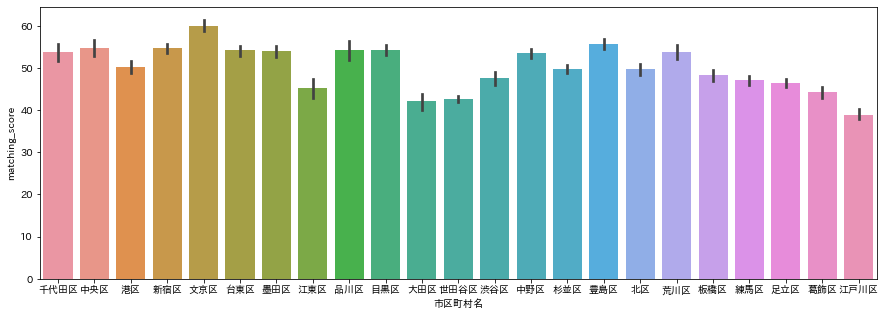

In [32]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='matching_score', data=df_my_town_score)
plt.show()

In [33]:
df_my_town_score['rank'] = df_my_town_score.groupby('町名')['matching_score'].transform('rank', ascending=False)
df_ranking = df_my_town_score[df_my_town_score['rank'] == 1].sort_values('matching_score', ascending=False)[
    ['地域ID', '市区町村名', '町丁目', '最寄り駅', 'matching_score',
     '子育てスコア', '教育スコア', '利便性スコア', '周辺環境スコア', '医療スコア', '治安スコア', room_type] + pop_rate_list
].reset_index(drop=True)
print(df_ranking.shape)

(869, 14)


In [34]:
df_ranking.head(10)

,地域ID,市区町村名,町丁目,最寄り駅,matching_score,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,治安スコア,家賃予測_1LDK,20代割合スコア,20代_子割合スコア
0,101141,千代田区,神田佐久間町４丁目,浅草橋駅,75.401429,2.504,2.739,4.185,2.600,4.431,4.695,14.28,4.897,4.775
1,104107,新宿区,改代町,飯田橋駅,74.005357,4.343,4.877,2.919,2.511,4.992,4.908,13.03,4.290,2.809
2,105032,文京区,小日向４丁目,飯田橋駅,72.976071,4.745,3.936,2.029,3.920,4.686,2.679,11.40,3.284,4.357
3,109126,品川区,西中延１丁目,荏原中延駅,71.785179,4.595,4.392,3.754,3.246,4.012,4.057,10.20,2.844,2.896
4,104066,新宿区,東五軒町,飯田橋駅,71.077679,4.985,4.783,3.831,2.205,2.878,3.598,13.03,2.772,3.694
5,104067,新宿区,西五軒町,飯田橋駅,71.048393,4.971,4.866,3.533,2.120,4.181,4.617,13.03,3.207,2.468
6,105021,文京区,千石１丁目,巣鴨駅,70.864464,4.731,4.956,2.257,4.141,3.886,2.714,11.28,1.920,3.980
7,101135,千代田区,東神田３丁目,浅草橋駅,70.009643,2.277,2.833,4.474,2.720,4.612,4.418,11.92,3.925,3.717
8,104068,新宿区,赤城元町,飯田橋駅,69.333393,4.687,4.816,3.570,2.483,4.109,4.157,13.03,2.511,3.248
9,105017,文京区,白山３丁目,巣鴨駅,69.164464,4.816,4.834,1.137,3.442,2.398,4.352,11.97,3.622,3.861


In [35]:
df_ranking['rank'] = df_ranking.groupby('最寄り駅')['matching_score'].transform('rank', ascending=False)
df_ranking_2 = df_ranking[df_ranking['rank'] == 1].sort_values('matching_score', ascending=False).drop(columns=['rank']).reset_index(drop=True)
print(df_ranking_2.shape)

(271, 14)


In [36]:
df_ranking_2.head(30)

,地域ID,市区町村名,町丁目,最寄り駅,matching_score,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,治安スコア,家賃予測_1LDK,20代割合スコア,20代_子割合スコア
0,101141,千代田区,神田佐久間町４丁目,浅草橋駅,75.401429,2.504,2.739,4.185,2.600,4.431,4.695,14.28,4.897,4.775
1,104107,新宿区,改代町,飯田橋駅,74.005357,4.343,4.877,2.919,2.511,4.992,4.908,13.03,4.290,2.809
2,109126,品川区,西中延１丁目,荏原中延駅,71.785179,4.595,4.392,3.754,3.246,4.012,4.057,10.20,2.844,2.896
3,105021,文京区,千石１丁目,巣鴨駅,70.864464,4.731,4.956,2.257,4.141,3.886,2.714,11.28,1.920,3.980
4,107061,墨田区,錦糸３丁目,錦糸町駅,68.966250,4.855,3.286,4.955,3.133,4.981,2.089,11.80,4.366,1.957
5,109110,品川区,平塚３丁目,戸越銀座駅,68.707500,3.335,4.532,4.002,3.405,4.539,4.352,12.07,2.717,2.380
6,118056,荒川区,西日暮里２丁目,日暮里駅,68.623214,4.425,4.402,4.851,1.404,4.936,0.066,12.22,4.176,3.163
7,107022,墨田区,菊川１丁目,両国駅,68.618036,3.897,4.851,2.515,2.717,3.986,3.129,10.72,3.901,2.961
8,109124,品川区,中延６丁目,中延駅,67.613750,4.939,2.936,4.318,2.461,4.472,3.650,11.83,2.431,2.898
9,120020,練馬区,豊玉中４丁目,練馬駅,67.471429,0.000,3.453,2.318,4.735,3.093,3.650,8.45,1.996,4.670


In [37]:
df_ranking_2.tail(10)

,地域ID,市区町村名,町丁目,最寄り駅,matching_score,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,治安スコア,家賃予測_1LDK,20代割合スコア,20代_子割合スコア
261,106130,台東区,上野公園,上野駅,34.094821,0.492,0.849,4.304,2.719,1.901,0.738,14.99,0.066,1.402
262,108084,江東区,有明１丁目,有明テニスの森駅,32.884464,0.805,0.361,2.650,1.102,0.346,0.633,10.67,0.455,4.980
263,111186,大田区,羽田旭町,整備場駅,32.318036,0.623,2.660,2.696,0.049,0.259,3.783,8.70,4.517,0.391
264,108089,江東区,辰巳１丁目,東雲駅,31.728929,0.000,2.960,0.554,1.043,0.758,0.532,8.59,0.111,2.603
265,108097,江東区,青海２丁目,テレコムセンター駅,27.476786,0.531,0.217,2.759,1.147,0.102,2.990,10.19,4.989,0.723
266,121236,足立区,西伊興町,舎人公園駅,25.796071,0.422,0.711,1.672,3.003,0.826,4.774,5.25,0.000,0.000
267,108187,江東区,新木場３丁目,新木場駅,17.890893,0.000,0.107,0.161,0.335,0.019,4.774,10.19,4.960,0.031
268,109157,品川区,東八潮,東京国際クルーズターミナル駅,16.075179,0.325,0.223,2.002,1.654,0.056,4.908,12.34,0.000,0.000
269,111200,大田区,羽田空港２丁目,羽田空港第3ターミナル駅,12.569821,0.007,2.025,1.945,0.013,0.221,2.066,9.37,0.000,0.000
270,111269,大田区,羽田沖水面,NaN,6.135000,0.000,0.000,0.000,0.005,0.000,4.908,6.84,0.000,0.000
